###  Use the gradient descent method to train a ReLU a shallow neural network for L^2 fitting tasks

Consider 1D  $L^2$-fitting problem on $\Omega = [-\pi,\pi]$: 
		\begin{equation}
			\min_{f_n \in \Sigma_n} \int_{-\pi}^\pi \frac{1}{2} | f(x) - f_n(x) |^2dx.
		\end{equation}
        
 $\Sigma_n$  is the spcae of  ReLU shallow neural network with $n$ neurons 
	\begin{equation*}
		\Sigma_n = \left\{ v(x) = \sum_{i=1}^n a_i \sigma(x + b_i) : a_i \in \mathbb{R},  ~~ b_i \in \mathbb{R}\right\}, \quad \sigma(x) = \max(0,x).
	\end{equation*}
    
The resulting nonlinear, nonconvex optimization problem
			\begin{equation} \label{snn-optimization}
			 \min_{a_i, b_i} \int_{-\pi}^{\pi} \frac{1}{2} |f(x) - \sum_{i=1}^{n} a_i \sigma( x + b_i) |^2 dx.  
		\end{equation}
	
The above optimization problem is usually solved by GD (or Adam). 

In [2]:
from helper_funcs import * 

In [3]:
def AdamOrGD_train(my_model, target,learning_rate,num_epochs,initialize_): 
    """Training SNN using Adam or GD

    Parameters
    ----------
    my_model : nn model class 
        Shallow neural network model 
    target : function
        the target function
    learning_rate : float 
        learning rate for neural network training 
    num_epochs : int 
        number of epochs
    initialize_ : function
        initialize the nn parameters

    Returns
    -------
    err : torch tensor
        L2 error history with respect to the epoch number 
    my_model : nn model class 
        trained nn model
    """
    
    def loss_function_inside(x): # Integrand of the loss function
        return 0.5*torch.pow(my_model(x)-target(x),2).to(device)

    start = time.time()
    hidden_size1 = my_model.fc1.bias.size(0)
    print("current hidden layer size: ",hidden_size1)
    if initialize_ != None: 
        initialize_(my_model,target)
        
    # Plot initial guess and compute initial error
    x_test = torch.linspace(-pi,pi,4096).view(4096,1).to(device) 
    u_true = target(x_test)
    plot_solution(-pi,pi,my_model,x_test,u_true)
    
    with torch.no_grad():
        node = compute_integration_nodes_relunn(-pi,pi,my_model)
        loss = GQ_piecewise(gw,gx,node,loss_function_inside)
    print("original loss", (2*loss)**0.5)
    # Define variables for data to be stored 
    err = torch.zeros(num_epochs+1, 1)
    err[0] = (2*loss)**0.5
    
    # Define optimizer 
    optimizer = optim.Adam(my_model.parameters(), lr=learning_rate)
    
    # Start the training process
    lr = learning_rate  
    for epoch in range(num_epochs):
        # Plot the numerical solution 
        if (epoch+1) % 5000 == 0: 
            plot_solution(-pi,pi,my_model,x_test,u_true)
          
        lr = learning_rate 
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr * (0.98 ** ((epoch + 1) // 1000)) # Learning rate schedule
        optimizer.zero_grad() # Clear gradient 
        
        # Define the loss function 
        node = compute_integration_nodes_relunn(-pi,pi,my_model)
        loss = GQ_piecewise(gw,gx,node,loss_function_inside)
        loss.backward() # Compute gradient 
        optimizer.step() # Gradient descent step
        with torch.no_grad(): 
            node = compute_integration_nodes_relunn(-pi,pi,my_model)
            loss = GQ_piecewise(gw,gx,node,loss_function_inside)
        err[epoch+1] = torch.pow(loss.detach()*2.0,0.5)

    # Plot L^2 error history and solution 
    plot_l2_error_history("Adam: ",hidden_size1,err)
    plot_solution(-pi,pi,my_model,x_test,u_true)
    end = time.time()
    print(str(end - start)+" s")
    return err, my_model

### Experiments

1. $f(x) = sin(x)$

2. $f(x) = sin(x) + 0.2*sin(10*x)$

current hidden layer size:  20


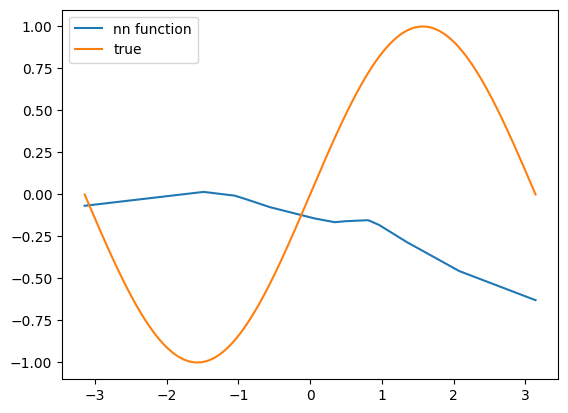

original loss tensor([[2.2095]])


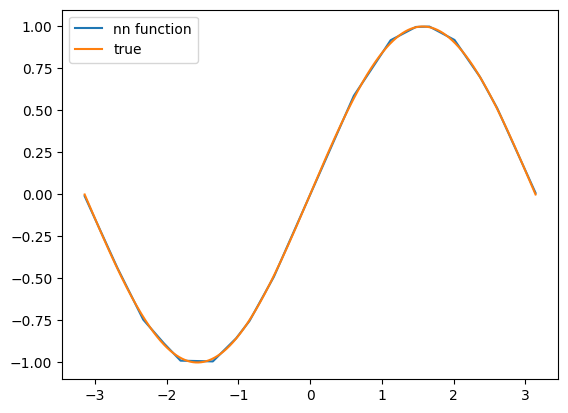

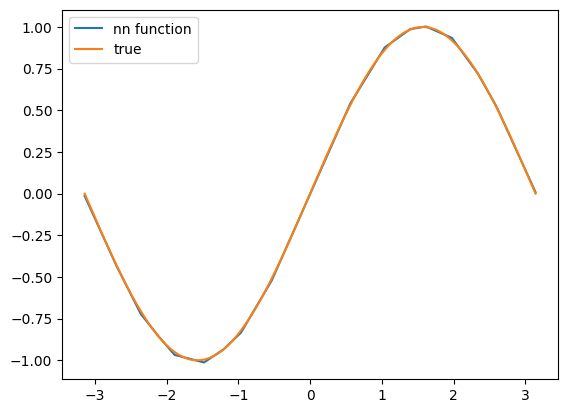

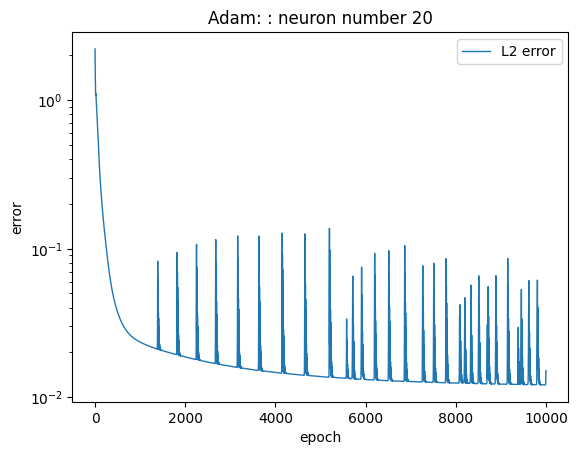

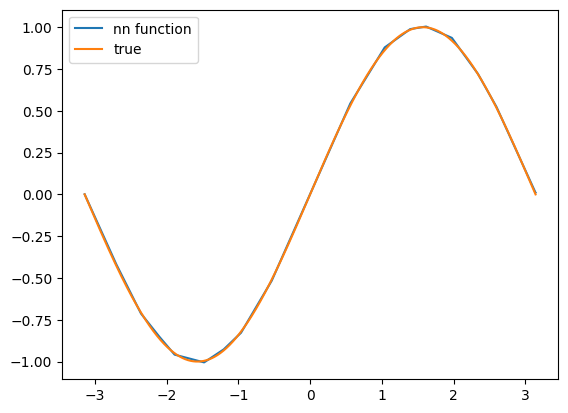

21.79885482788086 s


In [4]:
my_model = model(1,20,1)
def target(x):
    return torch.sin(x)
learning_rate = 0.01 
initialize_ = None 
num_epochs = 10000
err, my_model = AdamOrGD_train(my_model, target,learning_rate,num_epochs,initialize_)

In [ ]:
err_list = []
for neuron_num in [8,16,32,64,128,256]: 
    my_model = model(1,20,1)
    def target(x):
        return torch.sin(x) + 0.2*torch.sin(10*x)
    learning_rate = 0.01 
    initialize_ = None 
    num_epochs = 10000
    err, my_model = AdamOrGD_train(my_model, target,learning_rate,num_epochs,initialize_)
    err_list.append(err_list)
print(err_list)

current hidden layer size:  20


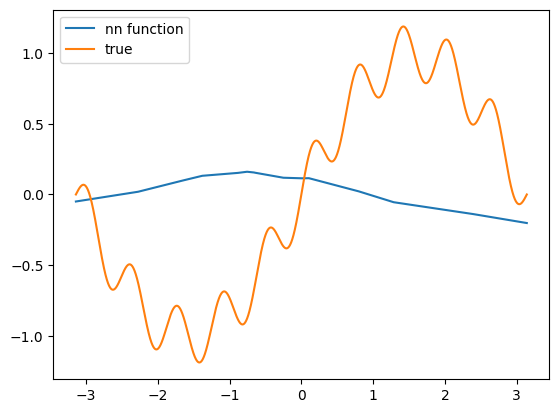

original loss tensor([[1.9874]])


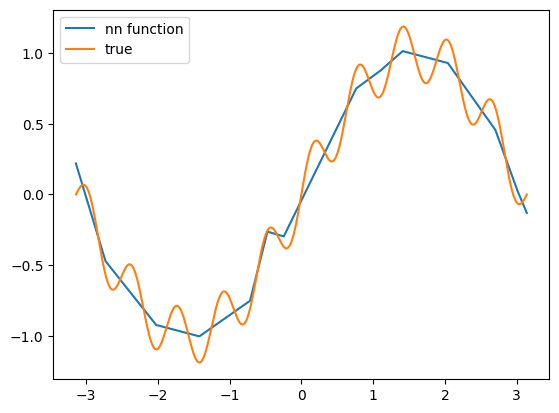

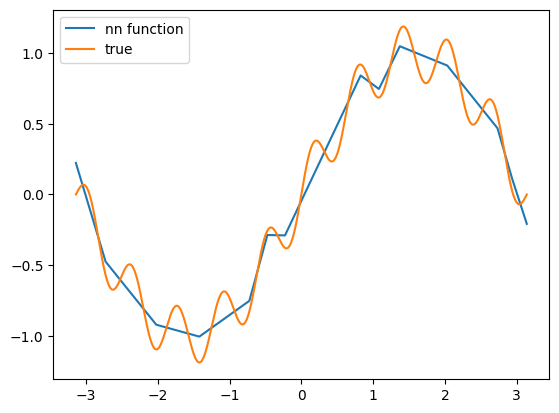

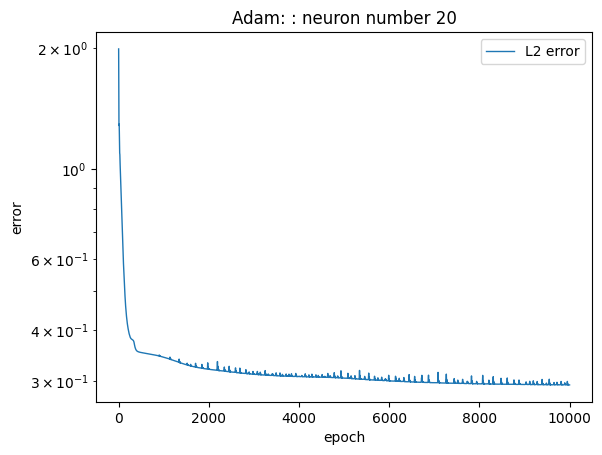

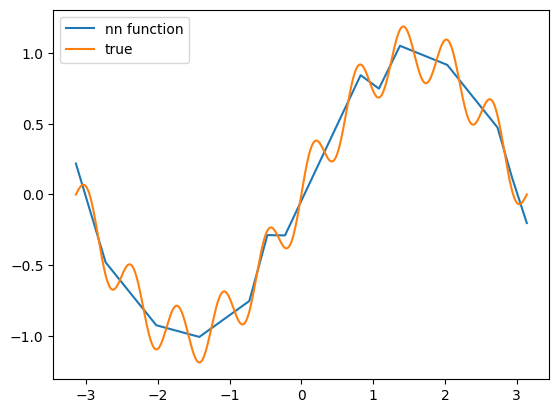

22.751142740249634 s


In [5]:
my_model = model(1,20,1)
def target(x):
    return torch.sin(x) + 0.2*torch.sin(10*x)
learning_rate = 0.01 
initialize_ = None 
num_epochs = 10000
err, my_model = AdamOrGD_train(my_model, target,learning_rate,num_epochs,initialize_)